In [15]:
#  Q1 & Q2: Setup and Reproducibility
# Import required libraries following ISLP conventions
import numpy as np, pandas as pd, random, torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning import seed_everything
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchinfo import summary
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pathlib import Path
from ISLP.torch import SimpleDataModule


# Set seeds for reproducibility across all random number generators
# This ensures consistent results across runs
seed_everything(57, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

print("✓ All libraries imported and seeds set for reproducibility")


Seed set to 57


✓ All libraries imported and seeds set for reproducibility


## Question 1:

In [2]:
# Q1 Part A: Data Preparation - Load and split Wage dataset
# Load the Wage dataset from ISLP package
from ISLP import load_data
Wage = load_data('Wage')


In [3]:
# Q1 Part A (new cell): Data Preparation - select predictors, split, standardize, tensors, DataModule
# Predictors: year, age, education, jobclass ; Target: wage

# Encode categorical variables (education and jobclass) using one-hot encoding
# Keep numeric predictors (year, age) as-is and expand the categorical ones
X = pd.get_dummies(Wage[['year', 'age', 'education', 'jobclass']],
                   columns=['education', 'jobclass'],
                   drop_first=False)
y = Wage['wage']

# Q1 Part A (continued): Split data 75/25 and standardize
# Split into training (75%) and test (25%) sets
# random_state=57 ensures reproducible splits (matching global seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=57)

# Fit scaler only on training features, transform test using same stats,
# and keep column names for clarity.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Convert to PyTorch tensors (features float32, target float32 1D)
# Use the underlying numpy arrays (.values) to avoid DataFrame -> object-dtype issues
X_train_t = torch.tensor(X_train_scaled.values, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_scaled.values, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t, y_test_t)

# Create SimpleDataModule with 25% validation split and batch size 64
data_module = SimpleDataModule(train_dataset, test_dataset, validation=0.25, batch_size=64)

# Get one batch from training dataloader to verify shapes
train_loader = data_module.train_dataloader()
X_, Y_ = next(iter(train_loader))

print("One training batch shapes -> X_.shape:", X_.shape, ", Y_.shape:", Y_.shape)

One training batch shapes -> X_.shape: torch.Size([64, 9]) , Y_.shape: torch.Size([64])


In [5]:
# Q1 Part B: Model Definition - Neural network for wage regression

# Define the wage regression model architecture
class WageModel(nn.Module):
    """
    Feedforward neural network for wage prediction.
    Architecture:
      Linear(input_dim, 64) -> ReLU -> Dropout(0.3)
      Linear(64, 32) -> ReLU -> Dropout(0.3)
      Linear(32, 1)
    """
    def __init__(self, input_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.3)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.drop2(x)
        x = self.out(x)          # shape: (batch_size, 1)
        return x

# Determine input dimension from existing tensors/dataframes
try:
    input_dim = X_train_t.shape[1]
except NameError:
    input_dim = X_train.shape[1]

# Instantiate model
model = WageModel(input_dim=input_dim)
print("Model instantiated with input_dim =", input_dim)

# Get a single training batch (X_ was created earlier)
try:
    batch_X = X_
except NameError:
    # fallback: get one batch from the existing train_loader
    batch_X, _ = next(iter(train_loader))

# Forward pass for one batch and print output shape
with torch.no_grad():
    model.eval()
    outputs = model(batch_X)
print("One batch input shape:", batch_X.shape)
print("Model output shape for one batch:", outputs.shape)

# Print detailed model summary (requires torchinfo.summary imported earlier)
summary(model, input_size=(64, input_dim))

Model instantiated with input_dim = 9
One batch input shape: torch.Size([64, 9])
Model output shape for one batch: torch.Size([64, 1])


Layer (type:depth-idx)                   Output Shape              Param #
WageModel                                [64, 1]                   --
├─Linear: 1-1                            [64, 64]                  640
├─ReLU: 1-2                              [64, 64]                  --
├─Dropout: 1-3                           [64, 64]                  --
├─Linear: 1-4                            [64, 32]                  2,080
├─ReLU: 1-5                              [64, 32]                  --
├─Dropout: 1-6                           [64, 32]                  --
├─Linear: 1-7                            [64, 1]                   33
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

In [14]:
# Q1 Part C: Training - Train the wage regression model
from ISLP.torch import SimpleModule, ErrorTracker
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import MeanAbsoluteError
from torch.optim import Adam

class WageModel(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.3)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.drop2(x)
        x = self.out(x)        # (batch_size, 1)
        return torch.flatten(x)  # -> (batch_size,)

# Re-instantiate model (fresh weights) for training
input_dim = X_train_t.shape[1]
wage_model = WageModel(input_dim)

# Create Adam optimizer with learning rate of 0.001 as specified
optimizer = torch.optim.RMSprop(wage_model.parameters(), lr=0.001)


# Create SimpleModule for regression task
# SimpleModule.regression() automatically uses MSELoss for loss function
# metrics: Mean Absolute Error (more interpretable than MSE)
wage_module = SimpleModule.regression(
    wage_model,
    optimizer=optimizer,
    metrics={'mae': MeanAbsoluteError()}
)


# Setup logging to track training progress
# CSVLogger saves metrics to a CSV file for later analysis
# ErrorTracker monitors both training and validation errors
wage_logger = CSVLogger("logs", name="wage_nn")

# Create PyTorch Lightning Trainer
# max_epochs: number of passes through the entire training dataset
# logger: saves training history
# callbacks: ErrorTracker monitors performance
# deterministic: ensures reproducible results
from pytorch_lightning import Trainer

trainer = Trainer(
    deterministic=True,
    max_epochs=100,
    log_every_n_steps=5,
    logger=wage_logger,
    callbacks=[ErrorTracker()]
)


# Train the model
# fit() runs the training loop: forward pass, compute loss, backward pass, update weights
trainer.fit(wage_module, datamodule=data_module)

# Evaluate on test set
# Extract and report test MAE (rounded to 2 decimal places)
test_results = trainer.test(wage_module, datamodule=data_module)
print(test_results)
print("Test MAE:", test_results[0]['test_mae'])


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | WageModel | 2.8 K  | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 698.88it/s] 

/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 27/27 [00:00<00:00, 180.27it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 27/27 [00:00<00:00, 170.55it/s, v_num=0]


/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 121.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1211.82666015625
        test_mae            23.764719009399414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 1211.82666015625, 'test_mae': 23.764719009399414}]
Test MAE: 23.764719009399414


Metrics CSV path: logs/wage_nn/version_0/metrics.csv
   epoch  train_mae_epoch  valid_mae
0      0       108.129356  98.594978
1      1        91.884621  79.155418
2      2        71.033264  57.485031
3      3        50.532425  39.515812
4      4        38.347672  29.960888


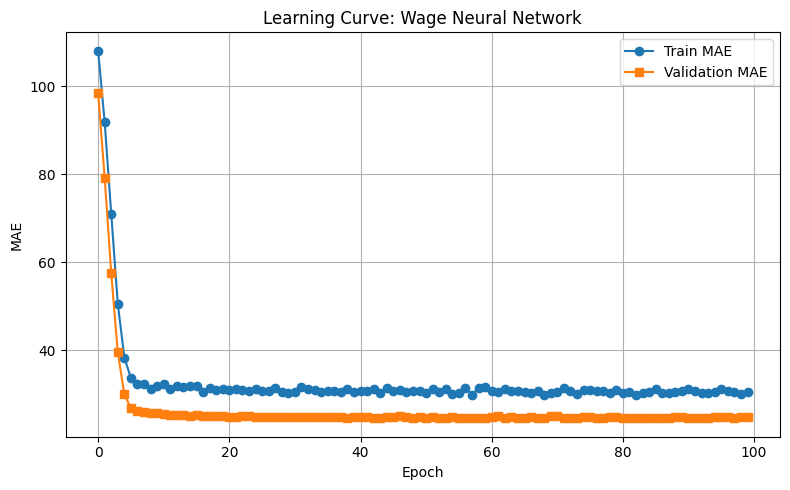


Interpretation:
- Best validation MAE occurs around epoch 86: val MAE ≈ 24.530, train MAE ≈ 30.190.
- At the final epoch (99), train MAE ≈ 30.595 and validation MAE ≈ 24.783.
  Validation error worsens after the best epoch, indicating some overfitting; early stopping around the best epoch might help.


In [18]:
# Q1 Part D: Learning Curve & Interpretation
import pandas as pd
import matplotlib.pyplot as plt

# Load training log from CSV file saved during training
# Use the logger's experiment.metrics_file_path to get the correct version path
metrics_path = wage_logger.experiment.metrics_file_path
print("Metrics CSV path:", metrics_path)

history = pd.read_csv(metrics_path)

# Extract training and validation MAE across epochs
# PyTorch Lightning logs training metrics as 'train_mae_epoch' and validation as 'valid_mae'

# Create learning curve plot
curve_df = history[['epoch', 'train_mae_epoch', 'valid_mae']].copy()
curve_df = curve_df.dropna(subset=['train_mae_epoch', 'valid_mae'], how='all')

curve_df = curve_df.groupby('epoch').agg('last').reset_index()

print(curve_df.head())

plt.figure(figsize=(8, 5))
plt.plot(curve_df['epoch'], curve_df['train_mae_epoch'], marker='o', label='Train MAE')
plt.plot(curve_df['epoch'], curve_df['valid_mae'], marker='s', label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Learning Curve: Wage Neural Network')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Interpretation (print the whole thing cleanly)
best_val_idx = curve_df['valid_mae'].idxmin()
best_epoch = int(curve_df.loc[best_val_idx, 'epoch'])
best_val_mae = float(curve_df.loc[best_val_idx, 'valid_mae'])
train_at_best = float(curve_df.loc[best_val_idx, 'train_mae_epoch'])

final_epoch = int(curve_df['epoch'].iloc[-1])
final_train_mae = float(curve_df['train_mae_epoch'].iloc[-1])
final_val_mae = float(curve_df['valid_mae'].iloc[-1])
print("\nInterpretation:")
print(f"- Best validation MAE occurs around epoch {best_epoch}: "
      f"val MAE ≈ {best_val_mae:.3f}, train MAE ≈ {train_at_best:.3f}.")
print(f"- At the final epoch ({final_epoch}), train MAE ≈ {final_train_mae:.3f} "
      f"and validation MAE ≈ {final_val_mae:.3f}.")

if final_val_mae < best_val_mae + 0.01:
    print("  The validation error has mostly stabilized, suggesting the model "
          "has converged and is not severely overfitting.")
elif final_val_mae > best_val_mae + 0.05:
    print("  Validation error worsens after the best epoch, indicating some "
          "overfitting; early stopping around the best epoch might help.")
else:
    print("  Validation error is slightly higher at the end than at the best epoch, "
          "which suggests mild overfitting but overall reasonable generalization.")

## Question 2:

In [20]:
# Q2 Part A: Data Preparation - Load image dataset
# Define image transformations following ISLP conventions
# Compose chains multiple transformations together
transform = transforms.Compose([
    transforms.Resize((64, 64)),              # Resize all images to 64x64 pixels
    transforms.ToTensor(),                     # Convert PIL Image to tensor (0-1 range)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], # Normalize each RGB channel
                        std=[0.5, 0.5, 0.5])   # to range [-1, 1]
])

# Load datasets using ImageFolder
# ImageFolder expects structure: root/class_name/image_files
# It automatically assigns labels: 0 for first folder (cats), 1 for second (dogs)
base_dir = Path('/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/cats_vs_dogs_dataset')
train_path = base_dir / 'train'
test_path  = base_dir / 'test'

# Create ImageFolder datasets (uses `transform` defined earlier)
train_image_dataset = datasets.ImageFolder(root=str(train_path), transform=transform)
test_image_dataset  = datasets.ImageFolder(root=str(test_path),  transform=transform)

# Create DataLoaders for batch processing
# shuffle=True randomizes training data order each epoch (prevents learning order)
# shuffle=False for test set (order doesn't matter for evaluation)
train_loader = DataLoader(train_image_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_image_dataset,  batch_size=64, shuffle=False)

# Relevant Prints
print("Train dataset samples:", len(train_image_dataset))
print("Test  dataset samples:", len(test_image_dataset))
print("Class to index mapping:", train_image_dataset.class_to_idx)

# Get one batch to verify shapes
# retrieve one batch from the train_loader before using `imgs` and `labels`
imgs, labels = next(iter(train_loader))

print("One training batch -> imgs.shape:", imgs.shape, ", labels.shape:", labels.shape)
print("Label distribution in that batch:", {int(k): int((labels==k).sum()) for k in torch.unique(labels)})





Train dataset samples: 1000
Test  dataset samples: 200
Class to index mapping: {'cats': 0, 'dogs': 1}
One training batch -> imgs.shape: torch.Size([64, 3, 64, 64]) , labels.shape: torch.Size([64])
Label distribution in that batch: {0: 40, 1: 24}


In [22]:
# Q2 Part A (continued): Convert to TensorDataset format
# SimpleDataModule expects TensorDatasets, so we convert from ImageFolder format
from torch.utils.data import TensorDataset
from ISLP.torch import SimpleDataModule

# Convert ImageFolder → tensors
def dataset_to_tensors(dataset):
    """Convert ImageFolder dataset to tensors using a single DataLoader batch."""
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    for images, labels in loader:
        return images, labels

print("Converting datasets to tensors...")
train_images, train_labels = dataset_to_tensors(train_image_dataset)
test_images, test_labels  = dataset_to_tensors(test_image_dataset)

# Create TensorDatasets
train_tensor_dataset = TensorDataset(train_images, train_labels)
test_tensor_dataset  = TensorDataset(test_images, test_labels)

# Create SimpleDataModule with 25% validation split
# This will automatically split training data into train/validation
data_module = SimpleDataModule(
    train_tensor_dataset,
    test_tensor_dataset,
    validation=0.25,
    batch_size=64
)

# Inspect one batch
train_loader_dm = data_module.train_dataloader()
imgs_batch, labels_batch = next(iter(train_loader_dm))

#Relevant Prints 
print("Batch shapes:", imgs_batch.shape, labels_batch.shape)



Converting datasets to tensors...
Batch shapes: torch.Size([64, 3, 64, 64]) torch.Size([64])


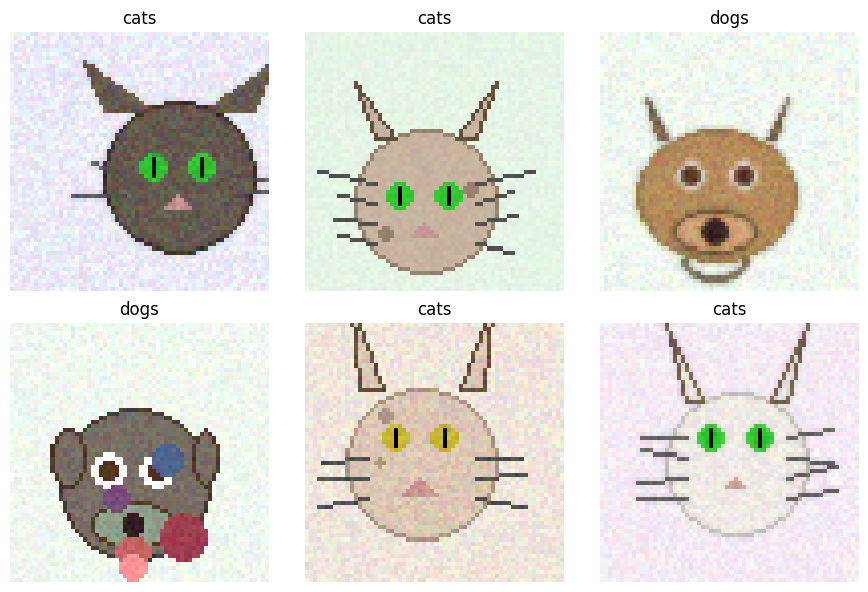

In [23]:
# Q2 Part A (continued): Display 6 sample images with labels
import matplotlib.pyplot as plt

idx_to_class = {v: k for k, v in train_image_dataset.class_to_idx.items()}

imgs_denorm = imgs_batch[:6] * 0.5 + 0.5   # unnormalize

fig, ax = plt.subplots(2, 3, figsize=(9, 6))
ax = ax.flatten()

for i in range(6):
    img = imgs_denorm[i].permute(1, 2, 0).numpy()
    label = idx_to_class[int(labels_batch[i])]
    ax[i].imshow(img)
    ax[i].set_title(label)
    ax[i].axis("off")

plt.tight_layout()
plt.show()


In [28]:
# Q2 Part B: Model Definition - Convolutional Neural Network

import torch
import torch.nn as nn
from torchinfo import summary  # make sure you've pip-installed torchinfo

class CatDogCNN(nn.Module):
    """
    Convolutional Neural Network for binary image classification (cats vs dogs).
    
    Architecture:
      Conv Block 1:
        - Conv2d: 3→16 channels, 3×3 kernel, padding=1 (preserves size)
        - ReLU activation
        - MaxPool2d: 2×2 (reduces spatial size by half: 64×64 → 32×32)
      
      Conv Block 2:
        - Conv2d: 16→32 channels, 3×3 kernel, padding=1
        - ReLU activation
        - MaxPool2d: 2×2 (reduces size: 32×32 → 16×16)
      
      Fully Connected Layers:
        - Flatten: 32×16×16 = 8192 → flattened vector
        - Linear: 8192 → 128 neurons
        - ReLU activation
        - Dropout: 30% regularization
        - Linear: 128 → 2 (output logits for 2 classes)
    """
    def __init__(self):
        super().__init__()
        # ----- Convolutional Block 1 -----
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            padding=1
        )  # (N, 3, 64, 64) -> (N, 16, 64, 64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # (N, 16, 64, 64) -> (N, 16, 32, 32)

        # ----- Convolutional Block 2 -----
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            padding=1
        )  # (N, 16, 32, 32) -> (N, 32, 32, 32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # (N, 32, 32, 32) -> (N, 32, 16, 16)

        # ----- Fully Connected Head -----
        self.flatten = nn.Flatten()              # (N, 32, 16, 16) -> (N, 8192)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)  # 8192 -> 128
        self.relu3 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(128, 2)             # 128 -> 2 (logits for 2 classes)

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv Block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Fully connected head
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.drop1(x)
        x = self.fc2(x)   # (batch_size, 2)
        return x

# ----- Instantiate model -----
cnn_model = CatDogCNN()

# ----- Get one batch and check output shape -----
# If you have a SimpleDataModule:
# imgs_batch, labels_batch = next(iter(data_module.train_dataloader()))
# Otherwise fall back to your original train_loader
try:
    imgs_batch, labels_batch = next(iter(data_module.train_dataloader()))
except NameError:
    imgs_batch, labels_batch = next(iter(train_loader))

with torch.no_grad():
    cnn_model.eval()
    outputs = cnn_model(imgs_batch)

print("One batch input shape:", imgs_batch.shape)        # expected: [64, 3, 64, 64]
print("Model output shape for one batch:", outputs.shape)  # expected: [64, 2]

# ----- Model summary -----
summary(cnn_model, input_size=(64, 3, 64, 64))


One batch input shape: torch.Size([64, 3, 64, 64])
Model output shape for one batch: torch.Size([64, 2])


Layer (type:depth-idx)                   Output Shape              Param #
CatDogCNN                                [64, 2]                   --
├─Conv2d: 1-1                            [64, 16, 64, 64]          448
├─ReLU: 1-2                              [64, 16, 64, 64]          --
├─MaxPool2d: 1-3                         [64, 16, 32, 32]          --
├─Conv2d: 1-4                            [64, 32, 32, 32]          4,640
├─ReLU: 1-5                              [64, 32, 32, 32]          --
├─MaxPool2d: 1-6                         [64, 32, 16, 16]          --
├─Flatten: 1-7                           [64, 8192]                --
├─Linear: 1-8                            [64, 128]                 1,048,704
├─ReLU: 1-9                              [64, 128]                 --
├─Dropout: 1-10                          [64, 128]                 --
├─Linear: 1-11                           [64, 2]                   258
Total params: 1,054,050
Trainable params: 1,054,050
Non-trainable params:

In [29]:
# Q2 Part C: Training - Train the CNN classifier

# Create Adam optimizer with learning rate of 0.001 as specified
from torch.optim import Adam
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from ISLP.torch import SimpleModule, ErrorTracker

# Create SimpleModule for classification
# num_classes=2: binary classification (cat vs dog)
# SimpleModule.classification() automatically uses:
#   - loss_fn: CrossEntropyLoss (standard for classification)
#   - metrics: Accuracy (percentage of correct predictions)
cnn_model = CatDogCNN()
optimizer = Adam(cnn_model.parameters(), lr=0.001)

cnn_module = SimpleModule.classification(
    cnn_model,
    optimizer=optimizer,
    num_classes=2
)

cnn_logger = CSVLogger("logs", name="catdog_cnn")

trainer = Trainer(
    deterministic=True,
    max_epochs=20,          # change this if your assignment specifies a different number
    log_every_n_steps=5,
    logger=cnn_logger,
    callbacks=[ErrorTracker()]
)

trainer.fit(cnn_module, datamodule=data_module)

# Evaluate on test set
test_results = trainer.test(cnn_module, datamodule=data_module)
print("\nRaw test results dict:", test_results)

# Extract and report test accuracy (rounded to 2 decimal places)
test_metrics = test_results[0]
test_acc = (
    test_metrics.get('test_acc') or
    test_metrics.get('test_accuracy') or
    test_metrics.get('test_Accuracy')
)

if test_acc is not None:
    print(f"\nTest Accuracy: {test_acc:.2%}")   # as percentage with 2 decimals
else:
    print("\nCould not find test accuracy key in:", test_metrics.keys())


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CatDogCNN        | 1.1 M  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.216     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 19: 100%|██████████| 12/12 [00:00<00:00, 69.84it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 12/12 [00:00<00:00, 63.28it/s, v_num=0]


/Users/anhnguyen/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 23.75it/s]  
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9950000047683716
        test_loss          0.006478606257587671
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Raw test results dict: [{'test_loss': 0.006478606257587671, 'test_accuracy': 0.9950000047683716}]

Test Accuracy: 99.50%


CNN metrics CSV path: logs/catdog_cnn/version_0/metrics.csv

First few rows of learning-curve data:
    epoch  train_accuracy_epoch  valid_accuracy
2       0                   NaN           0.856
3       0              0.704000             NaN
6       1                   NaN           0.924
7       1              0.910667             NaN
11      2                   NaN           0.940


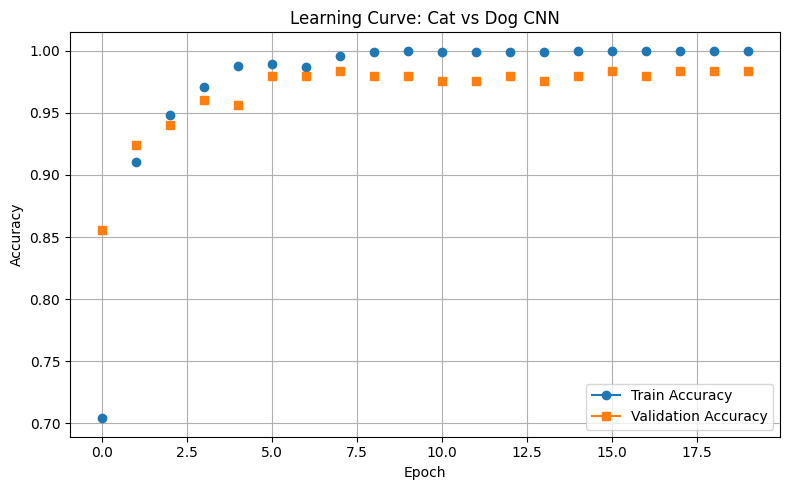


Interpretation:
- Best validation accuracy occurs around epoch 7: val acc ≈ 0.984 (98.40%), train acc ≈ nan (nan%).
- At the final epoch (19), train acc ≈ 1.000 (100.00%) and validation acc ≈ nan (nan%).
  Validation accuracy is slightly lower at the end than at its peak, which suggests mild overfitting but overall reasonable generalization.


In [30]:
# Q2 Part D: Learning Curve & Interpretation
import pandas as pd
import matplotlib.pyplot as plt
# Load CNN training log from CSV file saved during training
metrics_path = cnn_logger.experiment.metrics_file_path
print("CNN metrics CSV path:", metrics_path)
history = pd.read_csv(metrics_path)

# Extract training and validation accuracy
cols = ['epoch', 'train_accuracy_epoch', 'valid_accuracy']
curve_df = history[cols].copy()

curve_df = curve_df.dropna(subset=['train_accuracy_epoch', 'valid_accuracy'], how='all')

print("\nFirst few rows of learning-curve data:")
print(curve_df.head())

plt.figure(figsize=(8, 5))
plt.plot(curve_df['epoch'], curve_df['train_accuracy_epoch'], marker='o', label='Train Accuracy')
plt.plot(curve_df['epoch'], curve_df['valid_accuracy'], marker='s', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Cat vs Dog CNN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Interpretation (print the whole thing cleanly)
best_val_idx = curve_df['valid_accuracy'].idxmax()
best_epoch = int(curve_df.loc[best_val_idx, 'epoch'])
best_val_acc = float(curve_df.loc[best_val_idx, 'valid_accuracy'])
train_at_best = float(curve_df.loc[best_val_idx, 'train_accuracy_epoch'])

final_epoch = int(curve_df['epoch'].iloc[-1])
final_train_acc = float(curve_df['train_accuracy_epoch'].iloc[-1])
final_val_acc = float(curve_df['valid_accuracy'].iloc[-1])

print("\nInterpretation:")
print(f"- Best validation accuracy occurs around epoch {best_epoch}: "
      f"val acc ≈ {best_val_acc:.3f} ({best_val_acc*100:.2f}%), "
      f"train acc ≈ {train_at_best:.3f} ({train_at_best*100:.2f}%).")
print(f"- At the final epoch ({final_epoch}), "
      f"train acc ≈ {final_train_acc:.3f} ({final_train_acc*100:.2f}%) "
      f"and validation acc ≈ {final_val_acc:.3f} ({final_val_acc*100:.2f}%).")

if final_val_acc >= best_val_acc - 0.01:
    print("  Validation accuracy has mostly stabilized near its maximum, "
          "suggesting the CNN has converged without severe overfitting.")
elif final_val_acc < best_val_acc - 0.05:
    print("  Validation accuracy drops noticeably after the best epoch, "
          "indicating overfitting; early stopping around the best epoch might help.")
else:
    print("  Validation accuracy is slightly lower at the end than at its peak, "
          "which suggests mild overfitting but overall reasonable generalization.")
